Click [here](https://medium.com/@morihosseini/make-an-image-classification-app-9ce4904b2d38) to access the associated Medium article.

# Image classification

In this tutorial, we deploy a deep learning model for image classification using transfer learning. The problem that we are going to solve is to classify images of *ants* and *bees*. For that, we use PyTorch to train the model and Streamlit to provide a UI to interact with the model.

(Inspired by [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html))

In [1]:
# Install the dependencies
!pip install -r requirements.txt -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import copy
import pathlib
import requests
import zipfile

## Data

We will download 120 training images--a subset of ImageNet--for each of ants and bees and also, 75 validation images for each class. If we were going to do the classification from scratch, we would need to collect a lot more data, but since we are using *transfer learning*, we can get away with a small dataset.

**Note**: The dataset requires 45.2 MB of disk space.

In [3]:
def download(url, path: pathlib.Path, unzip=False, remove_zipped=False):
    """Download a file from url to path and potentially unzip it.

    Args:
        url (str): url to download from
        path (pathlib.Path): path to download to
        unzip (bool, optional): unzip the file. Defaults to False.
        remove_zipped (bool, optional): remove the zipped file. Defaults to
            False.
    """
    # create path if not exists
    if not path.is_file():
        path.parent.mkdir(parents=True, exist_ok=True)

    # add zip extension
    if unzip:
        path = path.with_suffix(".zip")

    # download
    r = requests.get(url, stream=True)
    total_len = int(r.headers.get("content-length"))
    chunk_size = 1024
    count = 0
    with open(path, "wb") as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                count += 1
                print(
                    f"Downloaded {count*chunk_size/total_len*100.0:.1f}%",
                    end="\r",
                )

    # unzip
    if unzip:
        with zipfile.ZipFile(path, "r") as zip_ref:
            zip_ref.extractall(path.parent)

    # remove zipped file
    if remove_zipped:
        path.unlink()

In [4]:
# download the dataset and extract it to the current directory
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_dir = pathlib.Path("hymenoptera_data")

if not data_dir.is_dir():
    download(url, data_dir, unzip=True, remove_zipped=True)

In [5]:
# data augmentation and normalization for training
# data normalization for validation
prep_img_mean = [0.485, 0.456, 0.406]
prep_img_std = [0.229, 0.224, 0.225]

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=prep_img_mean, std=prep_img_std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=prep_img_mean, std=prep_img_std),
        ]
    ),
}

image_datasets = {
    x: torchvision.datasets.ImageFolder(
        (data_dir / x).as_posix(), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

### Visualize sample images

Here we show some sample training images for ants and bees.

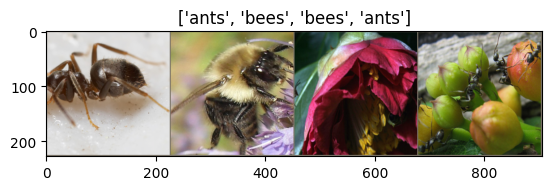

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    
    Args:
        inp (Tensor): Tensor of shape (C, H, W) to plot.
        title (str): Title of the plot.
    """
    mean = np.array(prep_img_mean)
    std = np.array(prep_img_std)
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train

Here, we provide generic functions to train a model and visualize the predictions.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """Train a model.

    Args:
        model: model to train
        criterion: loss function
        optimizer: optimizer
        scheduler: learning rate scheduler
        num_epochs: number of epochs to train for
    Returns:
        model: trained model
    """
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f"{phase}\tloss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training completed in "
        f"{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    print(f"Best val accuracy: {best_accuracy:.3f}")

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [8]:
def visualize_model(model, num_images=4):
    """Visualize model predictions.

    Args:
        model: model to visualize
        num_images: number of images to visualize
    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

## ConvNet as fixed feature extractor

Here, we freeze all the convolutional neural network (ConvNet) except the final fully connected layer.

**Note:** the regnet_x_3_2gf model weights need 15.3 MB of disk space.

In [9]:
model_conv = torchvision.models.regnet_x_3_2gf(
    weights=torchvision.models.RegNet_X_3_2GF_Weights.IMAGENET1K_V2
)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, len(class_names))

model_conv = model_conv.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay learning rate (LR) by a factor of gamma=0.1 every step_size=3 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_conv, step_size=3, gamma=0.1
)

### Train and evaluate

In this mode, gradients aren't computed for most of the network, but forward is computed.

In [10]:
model_conv = train_model(
    model=model_conv,
    criterion=criterion,
    optimizer=optimizer_conv,
    scheduler=exp_lr_scheduler,
    num_epochs=6,
)

Epoch 1/6
----------
train	loss: 0.526, accuracy: 0.795
val	loss: 0.343, accuracy: 0.948

Epoch 2/6
----------
train	loss: 0.324, accuracy: 0.889
val	loss: 0.344, accuracy: 0.935

Epoch 3/6
----------
train	loss: 0.372, accuracy: 0.832
val	loss: 0.235, accuracy: 0.948

Epoch 4/6
----------
train	loss: 0.355, accuracy: 0.848
val	loss: 0.206, accuracy: 0.961

Epoch 5/6
----------
train	loss: 0.284, accuracy: 0.922
val	loss: 0.220, accuracy: 0.922

Epoch 6/6
----------
train	loss: 0.319, accuracy: 0.857
val	loss: 0.257, accuracy: 0.954

Training completed in 4m 44s
Best val accuracy: 0.961


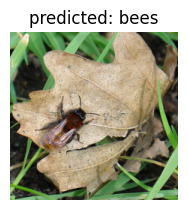

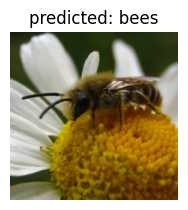

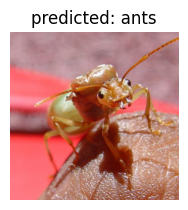

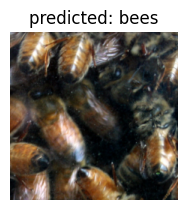

In [11]:
visualize_model(model=model_conv, num_images=4)

Save the model for later deployment in Streamlit. It requires 57.6 MB of disk space on my MacBook M1 machine.

In [12]:
saved_model_name = "model_img_class.pt"

torch.save(model_conv, saved_model_name)

## App

Here is the fun part!

We make an app, using Streamlit, to interact with the model we just trained.

**Note:** The following code writes to the app.py file.

In [13]:
%%writefile app.py
import streamlit as st
import torch
from torchvision import transforms
from PIL import Image
import argparse

CLASS_NAMES = ["ants", "bees"]
MODEL_NAME = "model_img_class.pt"


def predict(model_name, img_path):
    # load the model
    model = torch.load(model_name, map_location="cpu")

    # preprocess the image
    prep_img_mean = [0.485, 0.456, 0.406]
    prep_img_std = [0.229, 0.224, 0.225]
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=prep_img_mean, std=prep_img_std),
        ]
    )
    image = Image.open(img_path)
    preprocessed_image = transform(image).unsqueeze(0)

    # predict the class
    model.eval()
    output = model(preprocessed_image)
    pred_idx = torch.argmax(output, dim=1)
    predicted_class = CLASS_NAMES[pred_idx]
    return predicted_class


def create_app(model_name):
    # title
    st.title("Image Classification App")

    # file uploader
    uploaded_file = st.file_uploader(
        "Choose an image to classify", type=["jpg", "jpeg", "png"]
    )
    if uploaded_file is not None:
        st.write("")

        # predict the class
        predicted_class = predict(model_name, uploaded_file)

        col_left, col_right = st.columns(2)

        # the Predict button with the predicted class
        with col_left:
            if st.button("Predict"):
                emoji = ":honeybee:" if predicted_class == "bees" else ":ant:"
                st.markdown(f"## {predicted_class}  {emoji}")

        # display the image
        with col_right:
            image = Image.open(uploaded_file)
            st.image(image)


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--model", type=str, help="model name", default=MODEL_NAME
    )
    args = parser.parse_args()
    return args


if __name__ == "__main__":
    args = parse_args()
    create_app(model_name=args.model)


Overwriting app.py


Run the application with the following command, here or in terminal.

In [14]:
!streamlit run app.py